### Tutorial: Training a WSI Classification Model with CLAM on PANDA Dataset (MIL-Lab)

This tutorial trains a **Clustering-constrained Attention Multiple Instance Learning (CLAM)** model on the PANDA dataset using pre-extracted UNI v2 features.

**CLAM Key Features**:
- **Instance-level clustering**: Uses both bag-level and instance-level supervision
- **Top-K sampling**: Selects top/bottom K patches for instance-level training
- **Dual loss**: Combines bag-level classification loss with instance-level loss
- **Attention mechanism**: Gated attention for patch importance weighting

#### A- Dataset Information & Preprocessing

- **Dataset**: PANDA (Prostate cANcer graDe Assessment)
- **Features**: Pre-extracted UNI v2 features (1536 dimensions)
- **Patch size**: 256x256 pixels at 20x magnification
- **Task**: Multi-class classification (ISUP grades 0-5)
- **Data**:
  - WSI directory: `/media/nadim/Data/prostate-cancer-grade-assessment/train_images`
  - Features directory: `/media/nadim/Data/prostate-cancer-grade-assessment/panda/`
  - Labels CSV: `/media/nadim/Data/prostate-cancer-grade-assessment/train.csv`

**Preprocessing Steps**:
1. Read slide IDs and labels from CSV
2. Scan features directory for available .h5 files
3. Match CSV labels with available features
4. Perform stratified train/val/test split (70/20/10)

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from glob import glob

# Configuration
csv_path = '/media/nadim/Data/prostate-cancer-grade-assessment/train.csv'
feats_path = '/media/nadim/Data/prostate-cancer-grade-assessment/trident_processedqc/20x_256px_0px_overlap/features_uni_v2/'
SEED = 10

# ============================================================================
# GRADE GROUPING FLAGS
# ============================================================================
# Set to True to group ISUP grades into clinical categories:
#   Group 0: ISUP 0 (no cancer)
#   Group 1: ISUP 1 (low grade)
#   Group 2: ISUP 2-3 (mid grade)
#   Group 3: ISUP 4-5 (high grade)
# Set to False for original 6-class ISUP grading (0-5)
grade_group = True

# Set to True to exclude mid grade (ISUP 2-3) from analysis
# Only works when grade_group=True. Results in 3-class problem:
#   Group 0: ISUP 0 (no cancer)
#   Group 1: ISUP 1 (low grade)
#   Group 2: ISUP 4-5 (high grade)
exclude_mid_grade = True
# ============================================================================

# Set random seed for reproducibility
np.random.seed(SEED)

print(f"{'='*70}")
print("IMPROVED DATA PREPROCESSING")
if grade_group:
    if exclude_mid_grade:
        print("MODE: Clinical Grade Grouping WITHOUT Mid Grade (3 classes)")
    else:
        print("MODE: Clinical Grade Grouping (4 classes)")
else:
    print("MODE: Original ISUP Grading (6 classes)")
print(f"{'='*70}\n")

# Step 1: Read labels and slide IDs from CSV
print("Step 1: Reading labels from CSV...")
df_labels = pd.read_csv(csv_path)

# Select only necessary columns (slide_id and label)
df_labels = df_labels[['slide_id', 'label']]

# Store original ISUP grades
df_labels['isup_grade'] = df_labels['label']

# Apply grade grouping if enabled
if grade_group:
    # Exclude mid grade if requested
    if exclude_mid_grade:
        print(f"  Excluding mid grade (ISUP 2-3) from analysis...")
        df_labels = df_labels[~df_labels['isup_grade'].isin([2, 3])].reset_index(drop=True)
        print(f"  Remaining samples after exclusion: {len(df_labels)}")
    
    def map_isup_to_group(isup_grade):
        """Map ISUP grades to clinical groups"""
        if isup_grade == 0:
            return 0  # No cancer
        elif isup_grade == 1:
            return 1  # Low grade
        elif isup_grade in [2, 3]:
            return 2  # Mid grade
        elif isup_grade in [4, 5]:
            # If excluding mid grade, high grade becomes group 2, else group 3
            return 2 if exclude_mid_grade else 3  # High grade
        else:
            raise ValueError(f"Invalid ISUP grade: {isup_grade}")
    
    df_labels['label'] = df_labels['isup_grade'].apply(map_isup_to_group)
    print(f"  Applied grade grouping: ISUP -> Clinical Groups")
    
print(f"  Found {len(df_labels)} slides in CSV with labels")
print(f"  Label distribution in CSV:")
if grade_group:
    if exclude_mid_grade:
        group_names = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        group_names = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                       'Group 2 (Mid grade)', 'Group 3 (High grade)']
    for grade in sorted(df_labels['label'].unique()):
        count = len(df_labels[df_labels['label'] == grade])
        print(f"    {group_names[grade]}: {count}")
else:
    for grade in sorted(df_labels['label'].unique()):
        count = len(df_labels[df_labels['label'] == grade])
        print(f"    ISUP {grade}: {count}")

# Step 2: Find all available feature files
print(f"\nStep 2: Scanning features directory...")
feature_files = glob(os.path.join(feats_path, '*.h5'))
available_slide_ids = [os.path.basename(f).replace('.h5', '') for f in feature_files]
print(f"  Found {len(available_slide_ids)} feature files")

# Step 3: Match CSV with available features
print(f"\nStep 3: Matching CSV labels with available features...")
df_labels['has_features'] = df_labels['slide_id'].isin(available_slide_ids)
df_matched = df_labels[df_labels['has_features']].drop(columns=['has_features']).reset_index(drop=True)
missing_count = len(df_labels) - len(df_matched)
print(f"  Matched: {len(df_matched)} slides")
print(f"  Missing features: {missing_count} slides")
print(f"\n  Label distribution after matching:")
if grade_group:
    for grade in sorted(df_matched['label'].unique()):
        count = len(df_matched[df_matched['label'] == grade])
        print(f"    {group_names[grade]}: {count}")
else:
    for grade in sorted(df_matched['label'].unique()):
        count = len(df_matched[df_matched['label'] == grade])
        print(f"    ISUP {grade}: {count}")

# Step 4: Perform stratified train/val/test split using sklearn
print(f"\nStep 4: Performing stratified split (70% train, 20% val, 10% test)...")

# First split: separate test set (10%)
train_val_df, test_df = train_test_split(
    df_matched, 
    test_size=0.10, 
    stratify=df_matched['label'],
    random_state=SEED
)

# Second split: separate train and val from remaining 90% (77.78% train, 22.22% val of remaining)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.222,  # 0.222 * 0.9 ≈ 0.20 of total
    stratify=train_val_df['label'],
    random_state=SEED
)

# Add split column
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine back into single dataframe
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\n{'='*70}")
print("SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Total slides: {len(df)}\n")

print("Split distribution:")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nLabel distribution per split:")
for split_name in ['train', 'val', 'test']:
    split_df = df[df['split'] == split_name]
    print(f"\n{split_name.upper()}:")
    for grade in sorted(df['label'].unique()):
        count = len(split_df[split_df['label'] == grade])
        pct = count / len(split_df) * 100
        if grade_group:
            print(f"  {group_names[grade]}: {count:4d} ({pct:5.1f}%)")
        else:
            print(f"  ISUP {grade}: {count:4d} ({pct:5.1f}%)")

print(f"\n{'='*70}\n")

# Store number of classes for model creation
num_classes = len(df['label'].unique())
print(f"Number of classes: {num_classes}")
if grade_group:
    print(f"Class mapping: {group_names}")
else:
    print(f"Classes: ISUP grades 0-5")

# Display first few rows
df.head(10)

IMPROVED DATA PREPROCESSING
MODE: Clinical Grade Grouping WITHOUT Mid Grade (3 classes)

Step 1: Reading labels from CSV...
  Excluding mid grade (ISUP 2-3) from analysis...
  Remaining samples after exclusion: 8031
  Applied grade grouping: ISUP -> Clinical Groups
  Found 8031 slides in CSV with labels
  Label distribution in CSV:
    Group 0 (No cancer): 2892
    Group 1 (Low grade): 2666
    Group 2 (High grade): 2473

Step 2: Scanning features directory...
  Found 10615 feature files

Step 3: Matching CSV labels with available features...
  Matched: 8030 slides
  Missing features: 1 slides

  Label distribution after matching:
    Group 0 (No cancer): 2891
    Group 1 (Low grade): 2666
    Group 2 (High grade): 2473

Step 4: Performing stratified split (70% train, 20% val, 10% test)...

SPLIT SUMMARY
Total slides: 8030

Split distribution:
  Train: 5622 (70.0%)
  Val:   1605 (20.0%)
  Test:  803 (10.0%)

Label distribution per split:

TRAIN:
  Group 0 (No cancer): 2024 ( 36.0%)
  G

,slide_id,label,isup_grade,split
0,d14d2e2f09b3499b43ef1049691cfa73,0,0,train
1,c785544bb2e401f81d5b10b377ce829b,1,1,train
2,4aa3b5e41208988c1e018f2713b9e321,2,5,train
3,ecbafab43eea3abffc6cd89c02592e35,1,1,train
4,e34cba2807a8776c31fa61f63ac567cf,2,4,train
5,2b744f7f47a4fbd91e26eba3f37df819,0,0,train
6,da998451f0bdaf4e16b7b41c0881fcba,2,5,train
7,f91d27d0216aa979a0c89f465a03d990,1,1,train
8,c64c12966d164cd0bcc6bfef4ca95500,2,4,train
9,e0818000c58746e9ac0994202db988d0,0,0,train


#### B- Training a CLAM Model (using MIL-Lab)

**Important CLAM Notes**:
1. **Batch Size = 1**: CLAM processes one slide at a time
2. **Dual Loss**: Combines bag-level + instance-level loss
3. **Instance Loss**: Uses top-K and bottom-K patches for instance-level training
4. **Loss Function**: Must be provided during forward pass

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import MIL-Lab model builder
from src.builder import create_model

# Set deterministic behavior
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Custom dataset for PANDA (CLAM requires batch_size=1)
class PANDAH5Dataset(Dataset):
    def __init__(self, feats_path, df, split):
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.feats_path = feats_path
        self.split = split
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feat_path = os.path.join(self.feats_path, row['slide_id'] + '.h5')
        
        with h5py.File(feat_path, "r") as f:
            # Load ALL features (CLAM uses all patches)
            features = torch.from_numpy(f["features"][:]).squeeze(0)

        label = torch.tensor(row["label"], dtype=torch.long)
        return features, label

# Initialize MIL-Lab CLAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create CLAM model using MIL-Lab
# Model naming: 'clam.base_ce.uni_v2.none' means:
#   - clam: model architecture
#   - base_ce: configuration (CrossEntropy instance loss, no SVM)
#   - uni_v2: encoder type (automatically sets in_dim=1536)
#   - none: no pretrained weights (random initialization)
model = create_model(
    'clam.base_ce.uni_v2.none',  # CLAM with CE loss
    num_classes=num_classes,      # Use num_classes from preprocessing
    k_sample=8,                   # Sample 8 top/bottom patches for instance loss
    bag_weight=0.7                # 70% bag loss, 30% instance loss
).to(device)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Number of classes: {num_classes}")

# Create dataloaders (IMPORTANT: batch_size=1 for CLAM!)
feats_path = '/media/nadim/Data/prostate-cancer-grade-assessment/panda/'

train_dataset = PANDAH5Dataset(feats_path, df, "train")
val_dataset = PANDAH5Dataset(feats_path, df, "val")
test_dataset = PANDAH5Dataset(feats_path, df, "test")

# print the file name in the train_dataset to verify paths
for i in range(len(train_dataset)):
    features, label = train_dataset[i]
    print(f"Train sample {i}: features shape: {features.shape}, label: {label}")
    if i >= 2:  # Print only first 3 samples
        break
#also print the file name in the val_dataset to verify paths
for i in range(len(val_dataset)):
    features, label = val_dataset[i]
    print(f"Val sample {i}: features shape: {features.shape}, label: {label}")
    if i >= 2:  # Print only first 3 samples
        break
#also print the file name in the val_dataset to verify paths
for i in range(len(test_dataset)):
    features, label = test_dataset[i]
    print(f"Test sample {i}: features shape: {features.shape}, label: {label}")
    if i >= 2:  # Print only first 3 samples
        break
# CLAM requires batch_size=1
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

print(f"\nTrain samples: {len(train_loader)}")
print(f"Val samples: {len(val_loader)}")
print(f"Test samples: {len(test_loader)}")

/home/nadim/anaconda3/envs/mil2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nadim/anaconda3/envs/mil2/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/nadim/Source/MIL-Lab/src/builders/ModelDict.py:193: UserWarning: Pretrained flag is True, but task is set to 'none'. Using random weights
  warnings.warn("Pretrained flag is True, but task is set to 'none'. Using random weights")


Device: cuda
Model parameters: 1185930
Number of classes: 3
Train sample 0: features shape: torch.Size([608, 1536]), label: 0
Train sample 1: features shape: torch.Size([463, 1536]), label: 1
Train sample 2: features shape: torch.Size([557, 1536]), label: 2
Val sample 0: features shape: torch.Size([359, 1536]), label: 2
Val sample 1: features shape: torch.Size([320, 1536]), label: 2
Val sample 2: features shape: torch.Size([554, 1536]), label: 0
Test sample 0: features shape: torch.Size([629, 1536]), label: 0
Test sample 1: features shape: torch.Size([743, 1536]), label: 0
Test sample 2: features shape: torch.Size([560, 1536]), label: 0

Train samples: 5622
Val samples: 1605
Test samples: 803


#### C- Training Loop

**CLAM Training Notes**:
- Returns **dual loss**: bag-level + instance-level
- `log_dict` contains both `cls_loss` and `instance_loss`
- Total loss is weighted combination: `loss = bag_weight * cls_loss + (1 - bag_weight) * inst_loss`

In [3]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []
train_cls_losses = []
train_inst_losses = []

print(f"\n{'='*70}")
print("Starting CLAM training...")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0.
    total_cls_loss = 0.
    total_inst_loss = 0.
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for features, labels in train_bar:
        # CLAM takes features as [B, M, D] (B=1 for CLAM)
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # CLAM forward: MUST provide loss_fn and label
        results_dict, log_dict = model(features, loss_fn=criterion, label=labels)
        loss = results_dict['loss']
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_cls_loss += log_dict['cls_loss']
        total_inst_loss += log_dict['instance_loss']
        
        train_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'cls': f"{log_dict['cls_loss']:.4f}",
            'inst': f"{log_dict['instance_loss']:.4f}"
        })
    
    avg_train_loss = total_loss / len(train_loader)
    avg_cls_loss = total_cls_loss / len(train_loader)
    avg_inst_loss = total_inst_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_cls_losses.append(avg_cls_loss)
    train_inst_losses.append(avg_inst_loss)
    
    # Validation
    model.eval()
    val_loss = 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass with CLAM
            results_dict, log_dict = model(features, loss_fn=criterion, label=labels)
            logits = results_dict['logits']
            loss = results_dict['loss']
            
            val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss:     {avg_train_loss:.4f} (Cls: {avg_cls_loss:.4f}, Inst: {avg_inst_loss:.4f})")
    print(f"  Val Loss:       {avg_val_loss:.4f}")
    print(f"  Val Acc:        {val_acc:.4f}")
    print(f"  LR:             {new_lr:.6f}")
    
    if new_lr < old_lr:
        print(f"  >>> Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_clam_panda.pth')
        print(f"  >>> Saved best model (Val Loss: {best_val_loss:.4f})")
    
    print(f"{'-'*70}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"{'='*70}\n")


Starting CLAM training...



Epoch 1/10 [Val]: 100%|██████████| 1605/1605 [02:33<00:00, 10.46it/s]



Epoch 1/10 Summary:
  Train Loss:     0.2264 (Cls: 0.2974, Inst: 0.0608)
  Val Loss:       0.1628
  Val Acc:        0.9252
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.1628)
----------------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 1605/1605 [02:36<00:00, 10.29it/s]



Epoch 2/10 Summary:
  Train Loss:     0.1383 (Cls: 0.1907, Inst: 0.0161)
  Val Loss:       0.1668
  Val Acc:        0.9221
  LR:             0.000100
----------------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 1605/1605 [00:49<00:00, 32.61it/s]



Epoch 3/10 Summary:
  Train Loss:     0.1096 (Cls: 0.1527, Inst: 0.0089)
  Val Loss:       0.1427
  Val Acc:        0.9308
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.1427)
----------------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 1605/1605 [01:43<00:00, 15.49it/s]



Epoch 4/10 Summary:
  Train Loss:     0.0891 (Cls: 0.1247, Inst: 0.0060)
  Val Loss:       0.1418
  Val Acc:        0.9296
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.1418)
----------------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 1605/1605 [01:28<00:00, 18.21it/s]



Epoch 5/10 Summary:
  Train Loss:     0.0689 (Cls: 0.0962, Inst: 0.0050)
  Val Loss:       0.2189
  Val Acc:        0.9109
  LR:             0.000100
----------------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 1605/1605 [01:29<00:00, 17.97it/s]



Epoch 6/10 Summary:
  Train Loss:     0.0538 (Cls: 0.0751, Inst: 0.0039)
  Val Loss:       0.2055
  Val Acc:        0.9240
  LR:             0.000100
----------------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 1605/1605 [01:30<00:00, 17.74it/s]



Epoch 7/10 Summary:
  Train Loss:     0.0459 (Cls: 0.0639, Inst: 0.0038)
  Val Loss:       0.1852
  Val Acc:        0.9246
  LR:             0.000100
----------------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 1605/1605 [01:28<00:00, 18.05it/s]



Epoch 8/10 Summary:
  Train Loss:     0.0344 (Cls: 0.0478, Inst: 0.0033)
  Val Loss:       0.2091
  Val Acc:        0.9315
  LR:             0.000050
  >>> Learning rate reduced: 0.000100 -> 0.000050
----------------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 1605/1605 [01:30<00:00, 17.78it/s]



Epoch 9/10 Summary:
  Train Loss:     0.0168 (Cls: 0.0226, Inst: 0.0032)
  Val Loss:       0.2065
  Val Acc:        0.9377
  LR:             0.000050
----------------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 1605/1605 [01:29<00:00, 18.01it/s]


Epoch 10/10 Summary:
  Train Loss:     0.0111 (Cls: 0.0147, Inst: 0.0029)
  Val Loss:       0.2104
  Val Acc:        0.9358
  LR:             0.000050
----------------------------------------------------------------------

Training complete!
Best validation loss: 0.1418



#### D- Training Curves

Visualize the dual loss structure of CLAM

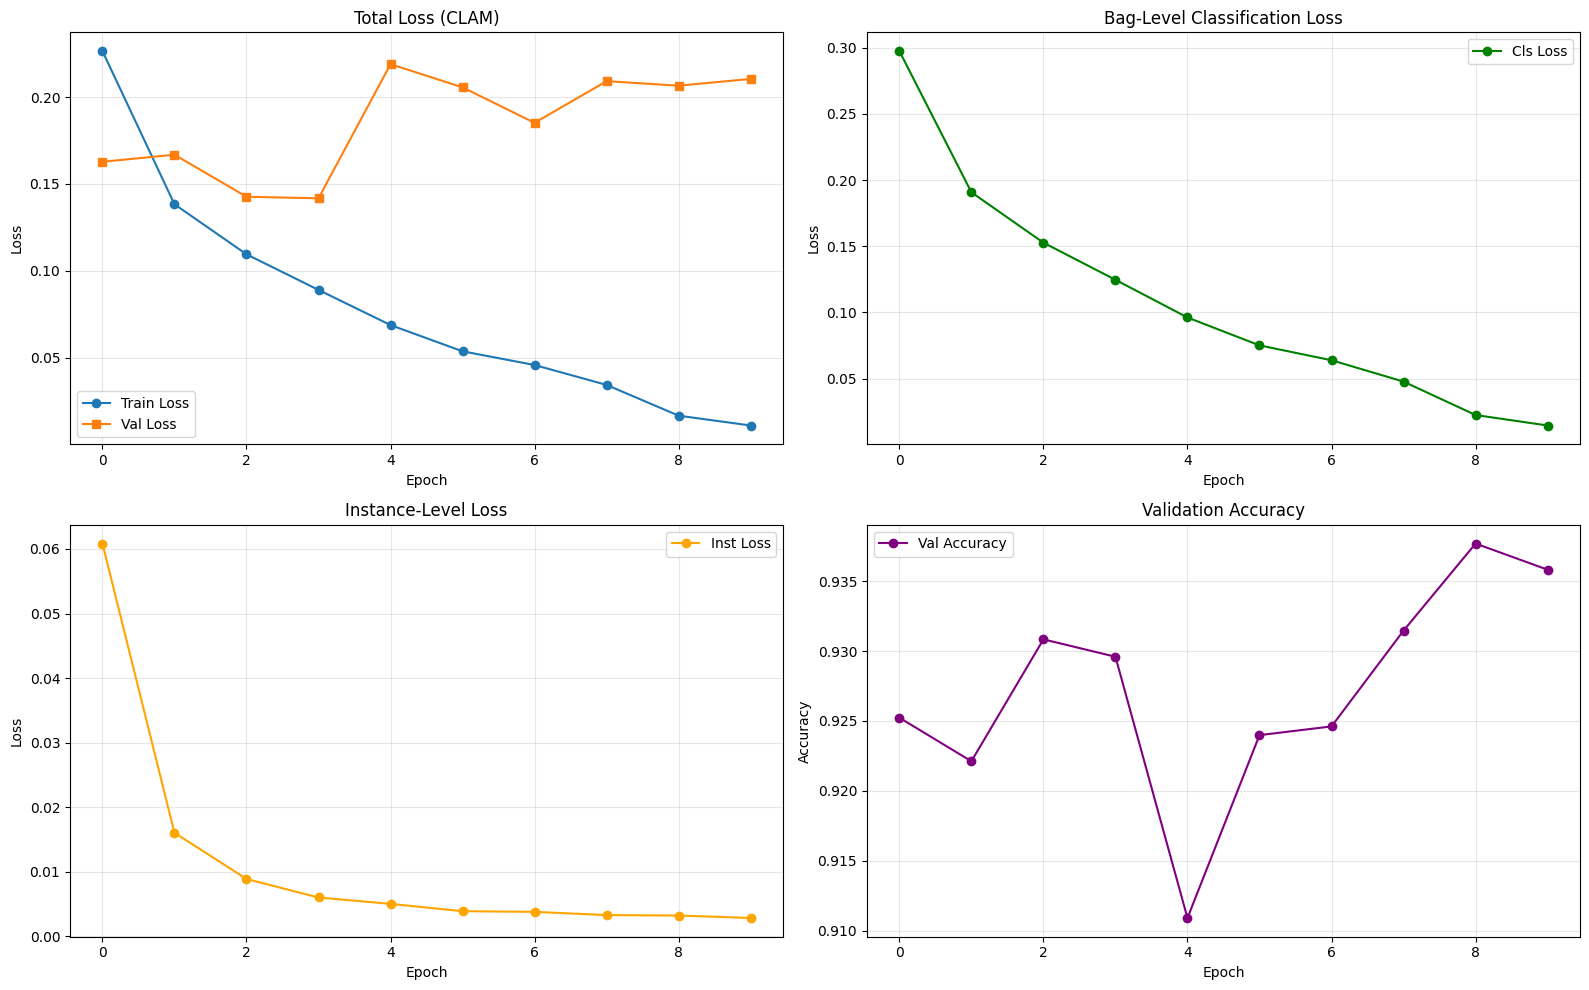

In [4]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Total loss
axes[0, 0].plot(train_losses, label='Train Loss', marker='o')
axes[0, 0].plot(val_losses, label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss (CLAM)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Classification loss
axes[0, 1].plot(train_cls_losses, label='Cls Loss', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Bag-Level Classification Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Instance loss
axes[1, 0].plot(train_inst_losses, label='Inst Loss', marker='o', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Instance-Level Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy
axes[1, 1].plot(val_accuracies, label='Val Accuracy', marker='o', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_clam_panda.png', dpi=300, bbox_inches='tight')
plt.show()

#### E- Test Evaluation

Testing: 100%|██████████| 803/803 [00:45<00:00, 17.79it/s]



CLAM Test Results
Test Accuracy:                    0.9290
Test Balanced Accuracy:           0.9292
Test Quadratic Weighted Kappa:    0.9271



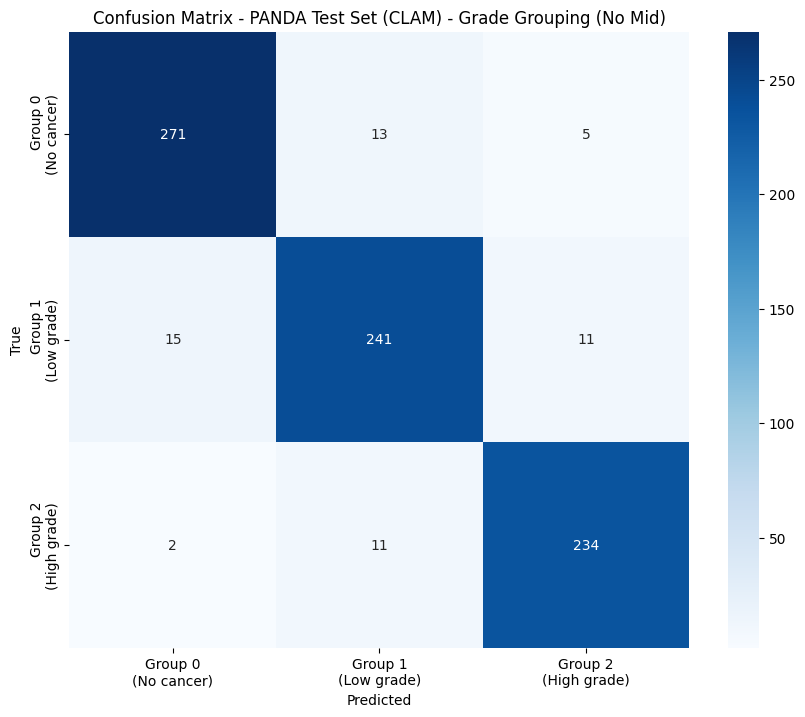


Per-class accuracy:
  Group 0 (No cancer): 0.9377 (271/289)
  Group 1 (Low grade): 0.9026 (241/267)
  Group 2 (High grade): 0.9474 (234/247)


In [5]:
# Load best model
model.load_state_dict(torch.load('best_model_clam_panda.pth'))
model.eval()

# Test evaluation
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc='Testing'):
        features, labels = features.to(device), labels.to(device)
        
        # CLAM forward pass - MUST provide loss_fn and label even during evaluation
        results_dict, log_dict = model(features, loss_fn=criterion, label=labels)
        logits = results_dict['logits']
        
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
test_balanced_acc = balanced_accuracy_score(all_labels, all_preds)
test_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

print(f"\n{'='*70}")
print("CLAM Test Results")
print(f"{'='*70}")
print(f"Test Accuracy:                    {test_acc:.4f}")
print(f"Test Balanced Accuracy:           {test_balanced_acc:.4f}")
print(f"Test Quadratic Weighted Kappa:    {test_kappa:.4f}")
print(f"{'='*70}\n")

# Generate class labels for confusion matrix
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0\n(No cancer)', 'Group 1\n(Low grade)', 'Group 2\n(High grade)']
    else:
        class_labels = ['Group 0\n(No cancer)', 'Group 1\n(Low grade)', 
                        'Group 2\n(Mid grade)', 'Group 3\n(High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
if grade_group:
    if exclude_mid_grade:
        plt.title('Confusion Matrix - PANDA Test Set (CLAM) - Grade Grouping (No Mid)')
    else:
        plt.title('Confusion Matrix - PANDA Test Set (CLAM) - Grade Grouping')
else:
    plt.title('Confusion Matrix - PANDA Test Set (CLAM)')
plt.savefig('confusion_matrix_clam_panda.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i in range(num_classes):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    if grade_group:
        print(f"  {class_labels[i].replace(chr(10), ' ')}: {class_acc:.4f} ({cm[i, i]}/{int(cm[i].sum())})")
    else:
        print(f"  ISUP {i}: {class_acc:.4f} ({cm[i, i]}/{int(cm[i].sum())})")

#### F- Visualization Helper Functions

Reusable functions to eliminate code duplication

In [6]:
import h5py
import torch
import openslide
from PIL import Image
import numpy as np
from src.visualization import TridentVisualizer

def load_slide_data(slide_id, feats_path, default_patch_size=256):
    """Load features, coordinates, and patch size for a given slide"""
    feat_path = os.path.join(feats_path, slide_id + '.h5')
    
    with h5py.File(feat_path, 'r') as f:
        patch_features = torch.from_numpy(f['features'][:]).squeeze(0)
        coords = f['coords_patching'][:]
        
        if hasattr(f['coords_patching'], 'attrs') and 'patch_size' in f['coords_patching'].attrs:
            patch_size_level0 = int(f['coords_patching'].attrs['patch_size'])
        else:
            patch_size_level0 = default_patch_size
    
    # Ensure coords and features have the same length
    min_len = min(len(coords), len(patch_features))
    coords = coords[:min_len]
    patch_features = patch_features[:min_len]
    
    return patch_features, coords, patch_size_level0

def get_clam_predictions(model, patch_features, true_label, criterion, device):
    """Get CLAM model predictions and attention scores"""
    model.eval()
    with torch.no_grad():
        features_input = patch_features.float().to(device).unsqueeze(0)
        label_tensor = torch.tensor([true_label], dtype=torch.long).to(device)
        
        # CLAM forward pass - MUST provide loss_fn and label
        results_dict, log_dict = model(
            features_input,
            loss_fn=criterion,
            label=label_tensor,
            return_attention=True
        )
        
        logits = results_dict['logits']
        attention_scores = log_dict['attention'].cpu().numpy().squeeze()
        predicted_class = torch.argmax(logits, dim=1).item()
        
    return predicted_class, attention_scores, logits

def extract_top_patches(slide_path, coords, attention_scores, patch_size_level0, top_k=3):
    """Extract top K patches based on attention scores"""
    # Get indices of top k patches
    top_indices = np.argsort(attention_scores)[-top_k:][::-1]
    
    # Open slide
    try:
        wsi = openslide.OpenSlide(slide_path)
    except:
        return None, None, None
    
    patches = []
    scores = []
    locations = []
    
    for idx in top_indices:
        x, y = coords[idx]
        score = attention_scores[idx]
        
        # Extract patch at level 0
        patch = wsi.read_region((int(x), int(y)), 0, (patch_size_level0, patch_size_level0))
        patch = patch.convert('RGB')
        
        patches.append(patch)
        scores.append(score)
        locations.append((x, y))
    
    wsi.close()
    return patches, scores, locations

print("Helper functions defined successfully!")

Helper functions defined successfully!


#### G- Top 3 Patches Per Category

Visualize the top 3 patches with highest attention scores for each ISUP grade

Extracting Top 3 Patches Per Clinical Grade Group (No Mid)

Processing Group 0 (No cancer): 0d11cd4b1285e9704ecd9fbee3ee8544
  Top 3 attention scores: [0.08589764, -0.698613, -0.7545635]
  Predicted: Group 0 (No cancer)

Processing Group 1 (Low grade): 51d0d7b3a0f1769117ed6e3d64445f33
  Top 3 attention scores: [6.623413, 6.4058657, 6.278801]
  Predicted: Group 1 (Low grade)

Processing Group 2 (High grade): d2e8ff5257ef522c1d7bef30c96d06df
  Top 3 attention scores: [9.18905, 8.464675, 8.350839]
  Predicted: Group 2 (High grade)



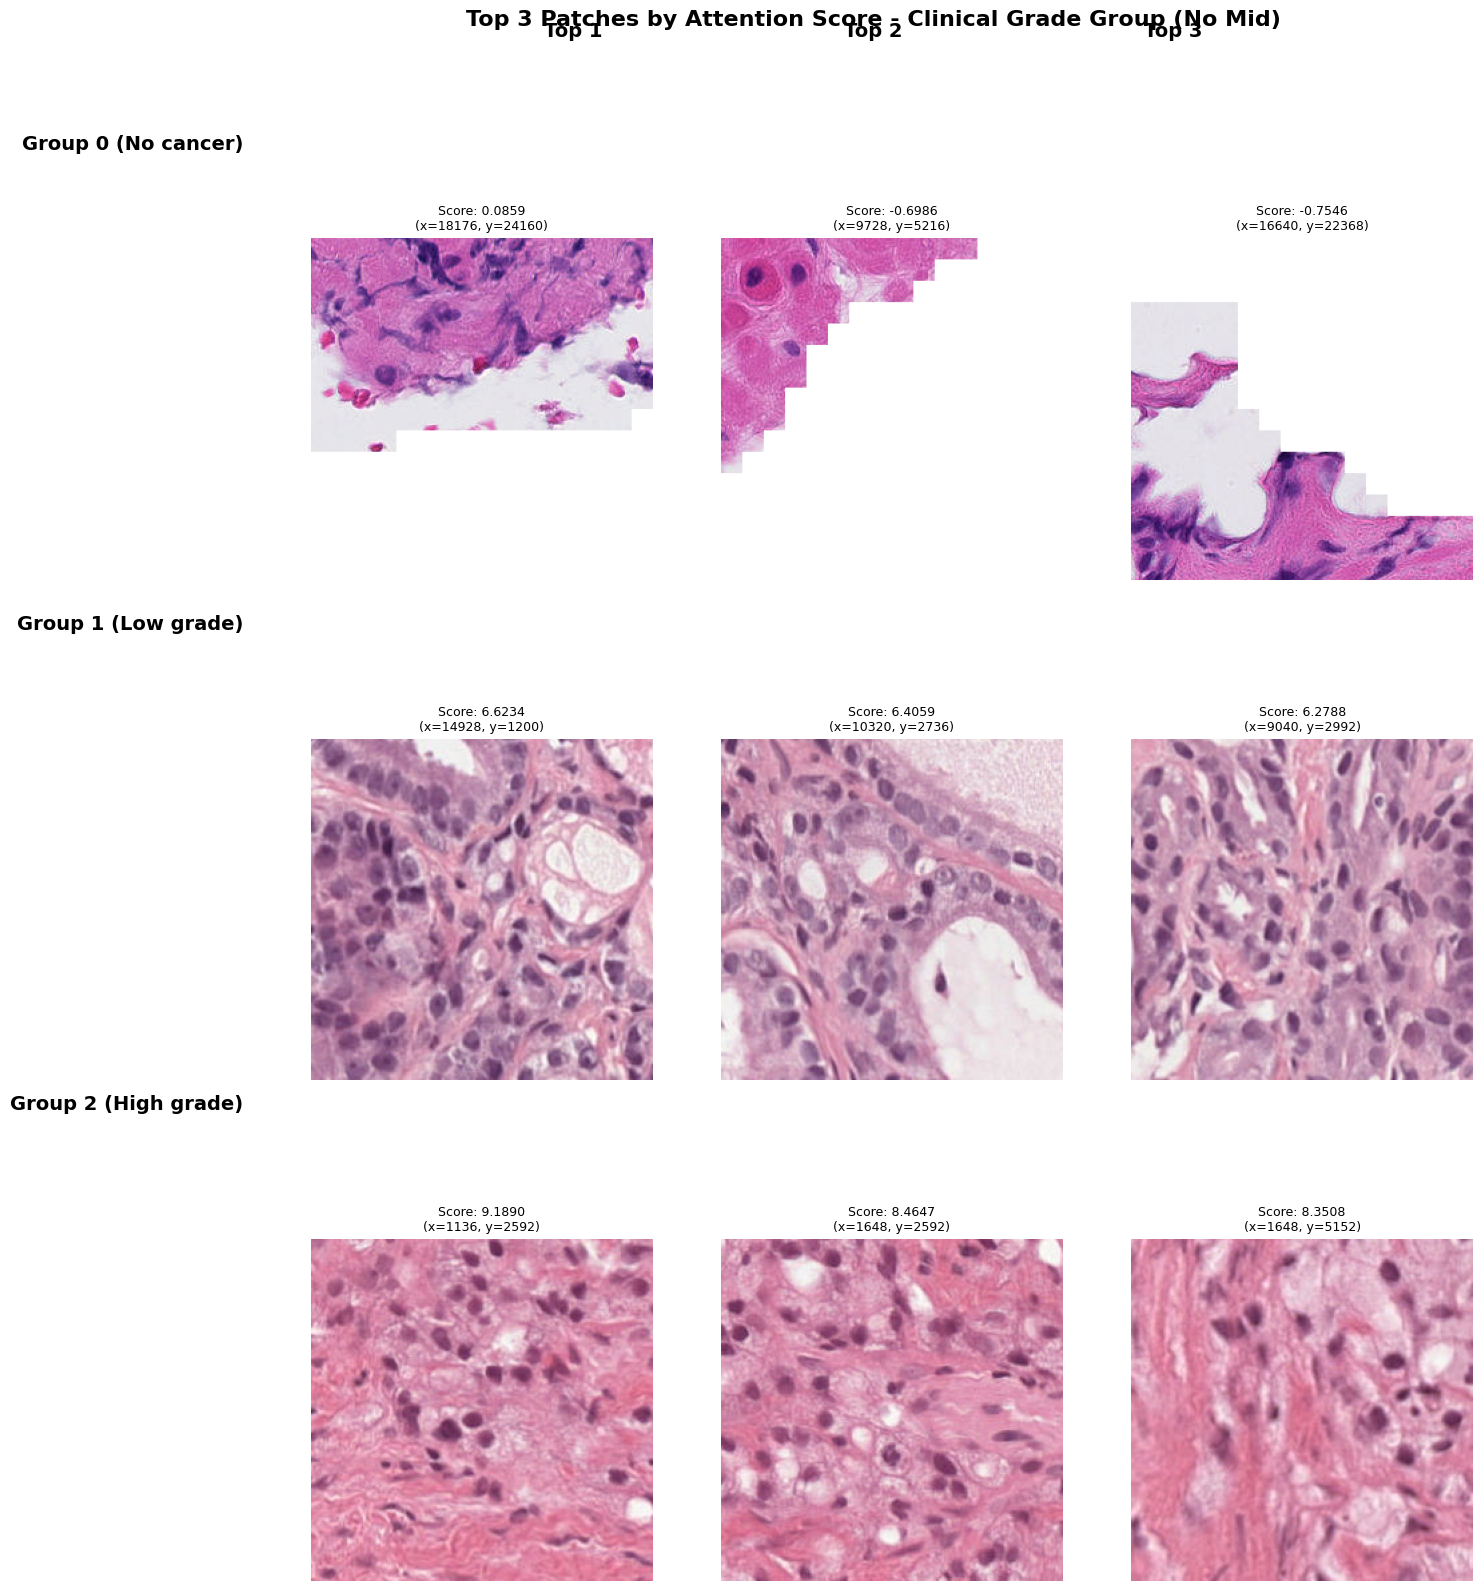


Top Patches Visualization Complete!
Saved to: ./heatmap_output_clam/top_3_patches_per_grade.png
Individual patches saved to: ./heatmap_output_clam/top_patches_per_grade/


In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Get one example from each class
test_df = df[df['split'] == 'test']
example_slides = []
for grade in range(num_classes):
    grade_slides = test_df[test_df['label'] == grade]
    if len(grade_slides) > 0:
        example_slides.append(grade_slides.iloc[0])

print(f"{'='*70}")
if grade_group:
    if exclude_mid_grade:
        print("Extracting Top 3 Patches Per Clinical Grade Group (No Mid)")
    else:
        print("Extracting Top 3 Patches Per Clinical Grade Group")
else:
    print("Extracting Top 3 Patches Per ISUP Grade")
print(f"{'='*70}\n")

# Create output directory for top patches
top_patches_dir = './heatmap_output_clam/top_patches_per_grade'
os.makedirs(top_patches_dir, exist_ok=True)

# Generate class labels
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                        'Group 2 (Mid grade)', 'Group 3 (High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

# Create figure with subplots: num_classes rows x 3 columns (top 3 patches)
fig = plt.figure(figsize=(15, 6*num_classes))
gs = GridSpec(num_classes, 3, figure=fig, hspace=0.3, wspace=0.2)

for grade_idx, slide_row in enumerate(example_slides):
    slide_id = slide_row['slide_id']
    true_label = slide_row['label']
    
    print(f"Processing {class_labels[true_label]}: {slide_id}")
    
    # Load slide data using helper function
    patch_features, coords, patch_size_level0 = load_slide_data(
        slide_id, feats_path, default_patch_size=256
    )
    
    # Get CLAM predictions and attention scores
    predicted_class, attention_scores, logits = get_clam_predictions(
        model, patch_features, true_label, criterion, device
    )
    
    # Extract top 3 patches
    slide_path = f'/media/nadim/Data/prostate-cancer-grade-assessment/train_images/{slide_id}.tiff'
    patches, scores, locations = extract_top_patches(
        slide_path, coords, attention_scores, patch_size_level0, top_k=3
    )
    
    if patches is None:
        print(f"  Could not load slide {slide_id}, skipping...")
        continue
    
    # Display top 3 patches for this grade
    for patch_idx, (patch, score, (x, y)) in enumerate(zip(patches, scores, locations)):
        ax = fig.add_subplot(gs[grade_idx, patch_idx])
        ax.imshow(patch)
        ax.axis('off')
        
        # Title with score and location
        title = f'Score: {score:.4f}\n(x={int(x)}, y={int(y)})'
        ax.set_title(title, fontsize=9)
        
        # Save individual patch
        if grade_group:
            patch_filename = f'Group{true_label}_{slide_id[:8]}_top{patch_idx+1}_score{score:.4f}.png'
        else:
            patch_filename = f'ISUP{true_label}_{slide_id[:8]}_top{patch_idx+1}_score{score:.4f}.png'
        patch.save(os.path.join(top_patches_dir, patch_filename))
    
    # Add row label on the left
    spacing = 0.92 - (grade_idx * (0.80 / num_classes))
    fig.text(0.08, spacing, class_labels[true_label], 
             va='center', ha='right', fontsize=14, fontweight='bold')
    
    print(f"  Top 3 attention scores: {scores}")
    print(f"  Predicted: {class_labels[predicted_class]}\n")

# Add column headers
fig.text(0.30, 0.98, 'Top 1', ha='center', fontsize=14, fontweight='bold')
fig.text(0.50, 0.98, 'Top 2', ha='center', fontsize=14, fontweight='bold')
fig.text(0.70, 0.98, 'Top 3', ha='center', fontsize=14, fontweight='bold')

if grade_group:
    if exclude_mid_grade:
        title_text = 'Top 3 Patches by Attention Score - Clinical Grade Group (No Mid)'
    else:
        title_text = 'Top 3 Patches by Attention Score - One Example per Clinical Grade Group'
else:
    title_text = 'Top 3 Patches by Attention Score - One Example per ISUP Grade'
plt.suptitle(title_text, fontsize=16, fontweight='bold', y=0.995)

# Save figure
output_path = os.path.join('./heatmap_output_clam', 'top_3_patches_per_grade.png')
plt.savefig(output_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print("Top Patches Visualization Complete!")
print(f"{'='*70}")
print(f"Saved to: {output_path}")
print(f"Individual patches saved to: {top_patches_dir}/")

#### H- Heatmap Visualization

Visualize CLAM attention heatmaps overlaid on whole slide images

CLAM Attention Heatmap Visualization
Visualizing 3 slides from different classes

Processing slide 1/3: 0d11cd4b1285e9704ecd9fbee3ee8544 (Group 0 (No cancer))

Creating Trident-style heatmap:
  WSI level 0 dimensions: (20480, 25600)
  Visualization level: 2
  Downsample: 16.0
  Region size: (1280, 1600)
  Number of patches: 629
  Score range (after rank normalization): [0.0016, 1.0000]
  Creating overlay...
  Applying colormap...
  Reading background image...
  Blending (alpha=0.4)...
  Saved to: ./heatmap_output_clam/0d11cd4b1285e9704ecd9fbee3ee8544_Group0_pred0_clam.png
  Done!
  Attention range: [-10.1003, 0.0859]
  Predicted: Group 0 (No cancer)

Processing slide 2/3: 51d0d7b3a0f1769117ed6e3d64445f33 (Group 1 (Low grade))

Creating Trident-style heatmap:
  WSI level 0 dimensions: (24576, 7168)
  Visualization level: 2
  Downsample: 16.0
  Region size: (1536, 448)
  Number of patches: 500
  Score range (after rank normalization): [0.0020, 1.0000]
  Creating overlay...
  Applying col

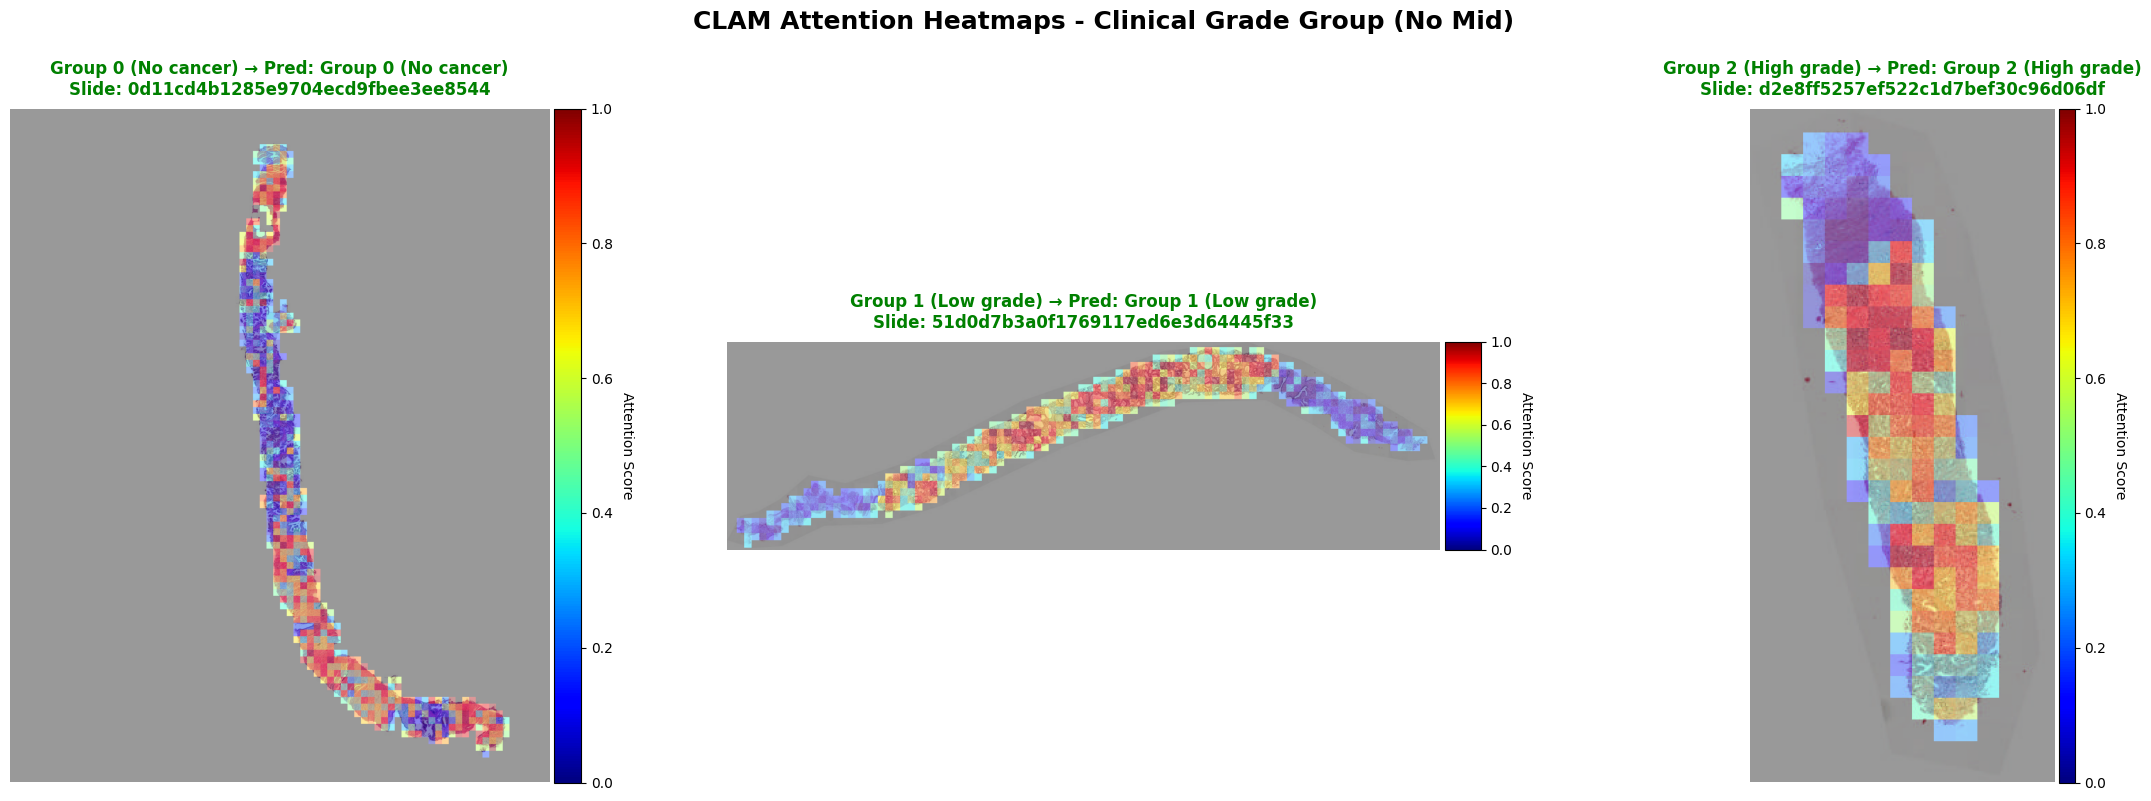


Heatmap Visualization Complete!
Output directory: ./heatmap_output_clam
- Individual heatmaps saved for each class
- Comparison grid: all_grades_comparison_clam.png


In [8]:
from src.visualization import TridentVisualizer
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get one example from each class
test_df = df[df['split'] == 'test']
example_slides = []
for grade in range(num_classes):
    grade_slides = test_df[test_df['label'] == grade]
    if len(grade_slides) > 0:
        example_slides.append(grade_slides.iloc[0])
    else:
        print(f"Warning: No test slides found for class {grade}")

# Generate class labels
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                        'Group 2 (Mid grade)', 'Group 3 (High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

print(f"{'='*70}")
print(f"CLAM Attention Heatmap Visualization")
print(f"{'='*70}")
print(f"Visualizing {len(example_slides)} slides from different classes\n")

# Create output directory
output_dir = './heatmap_output_clam'
os.makedirs(output_dir, exist_ok=True)

# Create figure with appropriate grid size
if num_classes == 3:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
elif num_classes == 4:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
else:
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for idx, slide_row in enumerate(example_slides):
    slide_id = slide_row['slide_id']
    true_label = slide_row['label']
    
    print(f"Processing slide {idx+1}/{len(example_slides)}: {slide_id} ({class_labels[true_label]})")
    
    # Load slide data using helper function
    patch_features, coords, patch_size_level0 = load_slide_data(
        slide_id, feats_path, default_patch_size=256
    )
    
    # Get CLAM predictions and attention scores using helper function
    predicted_class, attention_scores, logits = get_clam_predictions(
        model, patch_features, true_label, criterion, device
    )
    
    # Create heatmap using TridentVisualizer
    slide_path = f'/media/nadim/Data/prostate-cancer-grade-assessment/train_images/{slide_id}.tiff'
    viz = TridentVisualizer(model, wsi_path=slide_path)
    
    if grade_group:
        output_filename = f'{slide_id}_Group{true_label}_pred{predicted_class}_clam.png'
    else:
        output_filename = f'{slide_id}_ISUP{true_label}_pred{predicted_class}_clam.png'
    
    heatmap = viz.create_heatmap(
        features=patch_features,
        coords=coords,
        attention_scores=attention_scores,
        patch_size_level0=patch_size_level0,
        vis_level=-1,
        cmap='jet',
        alpha=0.4,
        normalize=True,
        output_path=os.path.join(output_dir, output_filename)
    )
    
    # Display heatmap with colorbar
    im = axes[idx].imshow(heatmap)
    axes[idx].axis('off')
    
    # Add colorbar
    divider = make_axes_locatable(axes[idx])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap='jet'), cax=cax)
    cbar.set_label('Attention Score', rotation=270, labelpad=15)
    
    # Title with true and predicted labels (green if correct, red if incorrect)
    title_color = 'green' if predicted_class == true_label else 'red'
    axes[idx].set_title(
        f'{class_labels[true_label]} → Pred: {class_labels[predicted_class]}\nSlide: {slide_id}',
        fontsize=12, fontweight='bold', color=title_color, pad=10
    )
    
    print(f"  Attention range: [{attention_scores.min():.4f}, {attention_scores.max():.4f}]")
    print(f"  Predicted: {class_labels[predicted_class]}\n")

# Hide unused subplots
if num_classes == 3:
    total_subplots = 3
elif num_classes == 4:
    total_subplots = 4
else:
    total_subplots = 6
for idx in range(len(example_slides), total_subplots):
    axes[idx].axis('off')

if grade_group:
    if exclude_mid_grade:
        title_text = 'CLAM Attention Heatmaps - Clinical Grade Group (No Mid)'
    else:
        title_text = 'CLAM Attention Heatmaps - One Example per Clinical Grade Group'
else:
    title_text = 'CLAM Attention Heatmaps - One Example per ISUP Grade'
    
plt.suptitle(title_text, fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_grades_comparison_clam.png'), dpi=200, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print("Heatmap Visualization Complete!")
print(f"{'='*70}")
print(f"Output directory: {output_dir}")
print(f"- Individual heatmaps saved for each class")
print(f"- Comparison grid: all_grades_comparison_clam.png")